 ### Load the drive containing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining function to group less represented parties under the 'Others' category

In [3]:
def creating_category_others(data):
  # Using .98 quantile to categorize 'Others'
  threshold_value = data['count'].quantile(.98)
  values_below_thresh = data['count'] < threshold_value
  data.loc[values_below_thresh,'Label'] = 'Others'
  return data

## Loading datasets

In [4]:
# Load dataset containing sport quotes
dataset = pd.read_csv('/content/drive/MyDrive/ADA/ada-sports-quotes/sport-quotes-2020.csv.bz2', compression='bz2', usecols=['speaker','qids','quoteID'])

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
dataset['qids'] = dataset['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(dataset['qids'])]

# Removing speakers without any known party (i.e. with 'party' == None)
politicians = speakers[~(speakers['party'].isna())]

## Computing the number of speakers per party from sport quotes

Only keeping the first qid for the 'party' feature. It is known, that it is not correct because we should select the party in which the speaker was at the time of the quote. This will be solved for Milestone 3, as this requires new speaker_features dataset to obtain this information. 

In [6]:
# Only keeping the first qid in the 'party' feature (with str.get(0))
# Counts the occurences of each party and adding the corresponding party label by merging qid_labels
party_speaker_counts_label = pd.DataFrame(pd.value_counts(politicians['party'].str.get(0))).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the .98 quantile to 'Others'
party_speaker_counts_label = creating_category_others(party_speaker_counts_label)

## Computing the number of quotes per party from sport quotes

In [7]:
# Selecting quotes from a speaker with a party and merging the speaker_attributes dataset
dataset_politicians_attributes = dataset[dataset['qids'].isin(politicians['id'])].merge(speaker_attributes, left_on='qids', right_on='id')
# Only keeping the first qid in the 'party' feature (with str.get(0))
dataset_politicians_attributes['party'] = dataset_politicians_attributes['party'].str.get(0)

# Counts the occurences of each party and add the corresponding party label 
party_quotes_counts_label = pd.DataFrame(pd.value_counts(dataset_politicians_attributes['party'])).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the .98 quantile to 'Others'
party_quotes_counts_label = creating_category_others(party_quotes_counts_label)

## Plots : pie plots and bar plots

Speaker's party distribution

Text(0.6, 0.92, "Speaker's party distribution of sport quotes for year 2020")

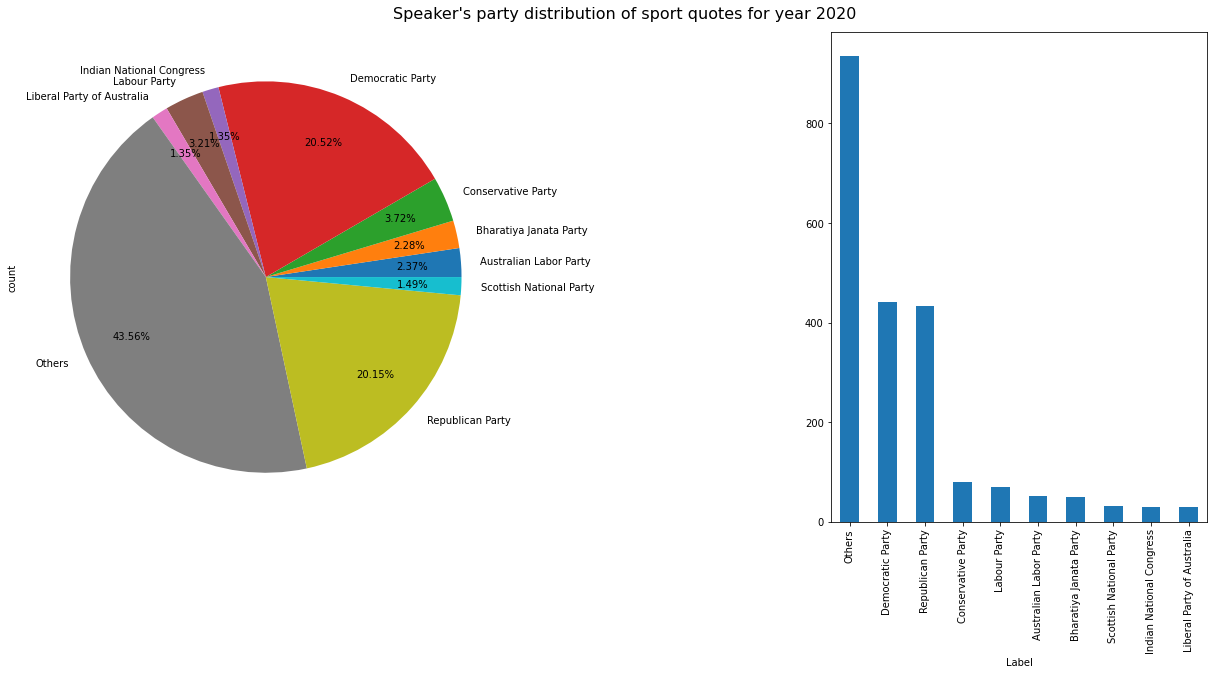

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_speaker_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], pctdistance=0.75)
party_speaker_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Speaker\'s party distribution of sport quotes for year 2020', fontsize=16, x=0.6, y=0.92)

Quote's party distribution

Text(0.6, 0.92, "Quote's party distribution of sport quotes for year 2020")

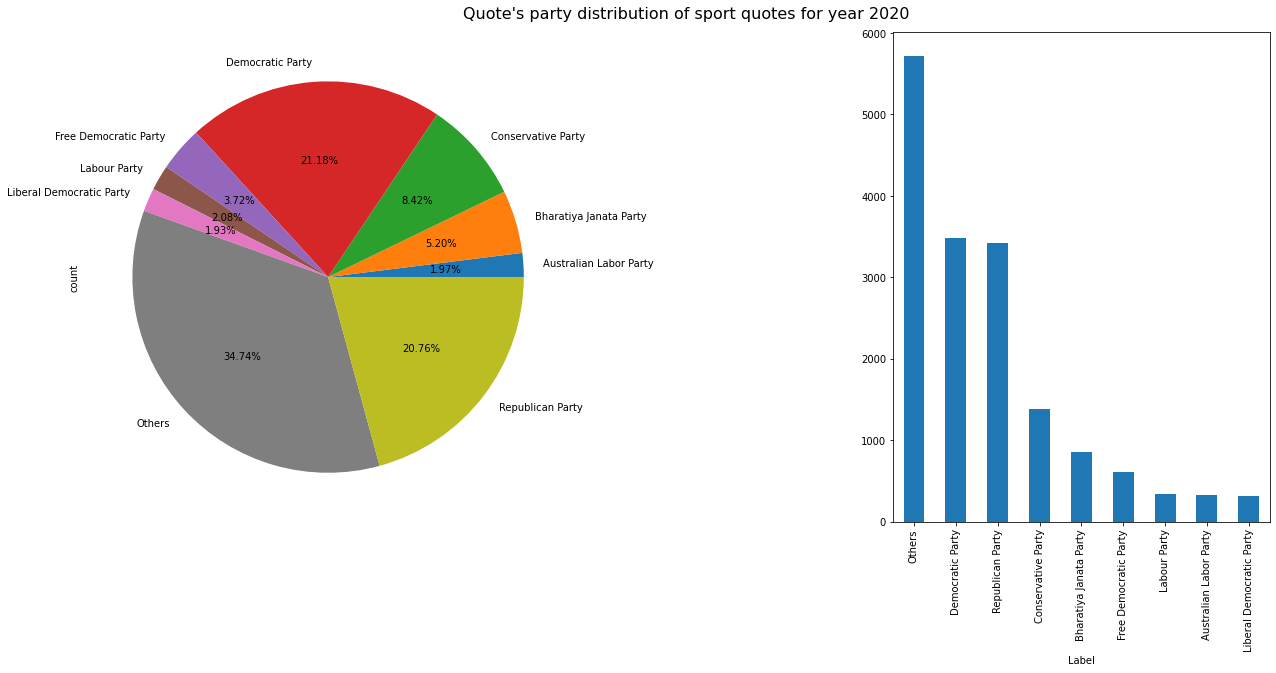

In [9]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_quotes_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0])
party_quotes_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Quote\'s party distribution of sport quotes for year 2020', fontsize=16, x=0.6, y=0.92)

## Data description and overview

Lengths of DataFrame (i.e. number of sample)

In [10]:
print('Number of sport quotes: {q_sport}\nNumber of political quotes: {q_pol}\nNumber of speakers: {spea}\nNumber of politicians (i.e. speakers with political party): {pol}\nNumber of different parties: {part}'\
      .format(q_sport=dataset.shape[0], spea=speakers.shape[0], pol=politicians.shape[0], part=party_speaker_counts_label.shape[0], q_pol=dataset_politicians_attributes.shape[0]))

Number of sport quotes: 641614
Number of political quotes: 16470
Number of speakers: 27828
Number of politicians (i.e. speakers with political party): 2149
Number of different parties: 392


In [11]:
dataset.sample(5)

,quoteID,speaker,qids
585744,2020-01-15-045524,Dave Johnson,"Q11693062', 'Q1632239', 'Q18221540', 'Q5229044..."
218320,2020-02-17-083954,KEITH ANDREWS,"Q27906360', 'Q316704"
331707,2020-02-04-071433,None,
552798,2020-01-01-012018,None,
425381,2020-03-14-010037,None,


In [12]:
speakers.sample(5)

,nationality,party,id
2469521,[Q30],None,Q7694171
5672088,"[Q15180, Q159]",None,Q311374
6866868,[Q145],None,Q2495295
3538176,None,None,Q5237332
1146720,[Q155],None,Q312886


In [13]:
politicians.sample(5)

,nationality,party,id
6976437,[Q408],[Q946040],Q6767168
7185148,[Q145],[Q10658],Q24034376
1446048,[Q30],[Q29552],Q16730158
5047724,[Q148],[Q17427],Q50825955
8056479,[Q30],"[Q29468, Q29552]",Q4898310


In [14]:
party_speaker_counts_label.head(5)

,count,Label,Description
QID,,,
Q29552,441,Democratic Party,political party in the United States
Q29468,433,Republican Party,major political party in the United States
Q9626,80,Conservative Party,political party in the United Kingdom
Q9630,69,Labour Party,political party in the United Kingdom
Q216082,51,Australian Labor Party,political party in Australia


In [15]:
dataset_politicians_attributes.sample(5)

,quoteID,speaker,qids,nationality,party,id
14507,2020-02-02-011995,Van Jones,Q3742492,[Q30],Q29552,Q3742492
14023,2020-02-17-017074,Peter Dutton,Q7173778,[Q408],Q1822905,Q7173778
7720,2020-02-12-127581,J.T. Wilcox,Q6104393,[Q30],Q29468,Q6104393
278,2020-03-21-015676,Sebastian Coe,Q188502,[Q145],Q9626,Q188502
5850,2020-04-10-003830,Shinzo Abe,Q132345,[Q17],Q232595,Q132345


In [16]:
party_quotes_counts_label.head(5)

,count,Label,Description
QID,,,
Q29552,3488,Democratic Party,political party in the United States
Q29468,3419,Republican Party,major political party in the United States
Q9626,1387,Conservative Party,political party in the United Kingdom
Q10230,857,Bharatiya Janata Party,major political party in India
Q13124,612,Free Democratic Party,political party in Germany
